# 1. Data loading and preprocessing

In [219]:
import os
import pandas as pd
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix


In [220]:
# Read the Parquet file into a DataFrame
# list of files in '../../../Data/All_Data/All_Data_with_NLP_Features'
import os
file_list = [f for f in os.listdir(r'/Users/chengzhengxing/Stat-222-Project/Data/All_Data/All_Data_with_NLP_Features') if f.endswith('.parquet')]
# read in all parquet files
df = pd.concat([pd.read_parquet(r'/Users/chengzhengxing/Stat-222-Project/Data/All_Data/All_Data_with_NLP_Features/' + f) for f in file_list])

# 2. Model

In [221]:
def train_and_evaluate_model(df, numeric_feature_columns, cat_feature_columns, target_column, custom_mapping, test_size=None, random_state=None,
                             penalty='l1', class_weight=None, max_iter=5000, solver="saga",multi_class="ovr", change =False):
    """
    Trains and evaluates a logistic regression model.

    Parameters:
    - df: DataFrame containing the dataset.
    - numeric_feature_columns: list of numeric columns to be used as features.
    - cat_feature_columns: list of categorical columns to be used as features.
    - target_column: column to be used as target.
    - custom_mapping: dictionary to encode the target variable.
    - test_size: proportion of the dataset to include in the test split.
    - random_state: controls the shuffling applied to the data before applying the split.
    - penalty: regularization type ('l1' or 'l2').
    - class_weight: weights associated with classes. If not given, all classes are supposed to have weight one.
    - max_iter: maximum number of iterations taken for the solvers to converge.
    - solver: optimizer choice
    - multi_class: multinomial class ('ovr' or 'multinomial')
    - change: whether predict changes (default is predict true label)

    Returns:
    A dictionary with accuracy, F1 score, and majority class baseline.
    """
    
    # Selecting features and target, and encoding target
    
    if test_size:
        # Splitting data
        numeric_X = df[numeric_feature_columns].select_dtypes(include=['int64', 'float64'])
        cat_X = df[cat_feature_columns]
        X = pd.concat([numeric_X, cat_X], axis=1)
        
        if change:
            Y = df[target_column].map({-2: 'downgrade', -1: 'downgrade', 0: 'no change', 1: 'upgrade', 2: 'upgrade'}).map(custom_mapping)
        else:
            Y = df[target_column].map(custom_mapping)
            
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=random_state)
    else:
        train_df = df[df['train_test_80_20'] == 'train']
        test_df = df[df['train_test_80_20'] == 'test']

        train_numeric_X = train_df[numeric_feature_columns].select_dtypes(include=['int64', 'float64'])
        train_cat_X = train_df[cat_feature_columns]
    
        test_numeric_X = test_df[numeric_feature_columns].select_dtypes(include=['int64', 'float64'])
        test_cat_X = test_df[cat_feature_columns]

        X_train = pd.concat([train_numeric_X, train_cat_X], axis=1)
        X_test = pd.concat([test_numeric_X, test_cat_X], axis=1)

        if change:
            y_train = train_df[target_column].map({-2: 'downgrade', -1: 'downgrade', 0: 'no change', 1: 'upgrade', 2: 'upgrade'}).map(custom_mapping)
            y_test = test_df[target_column].map({-2: 'downgrade', -1: 'downgrade', 0: 'no change', 1: 'upgrade', 2: 'upgrade'}).map(custom_mapping)
        else:
            y_train =  train_df[target_column].map(custom_mapping)
            y_test = test_df[target_column].map(custom_mapping)
    


    # Preprocessing
    numeric_transformer = StandardScaler()
    cat_transformer = OneHotEncoder(handle_unknown='ignore')

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_feature_columns),
            ('cat', cat_transformer, cat_feature_columns)
        ])

    X_train_scaled = preprocessor.fit_transform(X_train)
    X_test_scaled = preprocessor.transform(X_test)

    # Model training
    model = LogisticRegression(penalty=penalty, max_iter=max_iter, class_weight=class_weight, solver=solver, multi_class=multi_class)
    model.fit(X_train_scaled, y_train)
    
    # Model prediction and evaluation
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    majority_class_share_baseline = y_test.value_counts(normalize=True).max()
    
    print({'accuracy': accuracy, 'f1_score': f1, 'majority_baseline': majority_class_share_baseline})
    
    ### Calculate the share of predictions that are 1 or fewer ratings away from the actual ratings
    differences = np.abs(y_pred - y_test)
    close_predictions_share = np.mean(differences <= 1)
    exact_predictions_share = np.mean(differences == 0 )

    print(f"Share of predictions exactly as the actual: {exact_predictions_share:.2%}")
    print(f"Share of predictions 1 or fewer ratings away from actual: {close_predictions_share:.2%}")

    ### confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)

    display_labels = []
    for v in np.sort(np.unique(y_test)):
        for key, value in custom_mapping.items():
            if value == v:
                display_labels.append(key)
                
    # Confusion Matrix Display
    cm_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,display_labels=display_labels)

    # Plot Confusion Matrix
    plt.figure(figsize=(10, 8))
    cm_display.plot(cmap='Blues', ax=plt.gca(), xticks_rotation='vertical')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

    

In [222]:
# Load the JSON file
with open('/Users/chengzhengxing/Stat-222-Project/Code/feature_columns.json', 'r') as file:
    column_data = json.load(file)

## Task1: Credit Rating prediction 

### model 1
First, we only use the Altman_Z as covariate

{'accuracy': 0.4376391982182628, 'f1_score': 0.41870365930224773, 'majority_baseline': 0.31625835189309576}
Share of predictions exactly as the actual: 43.76%
Share of predictions 1 or fewer ratings away from actual: 84.19%


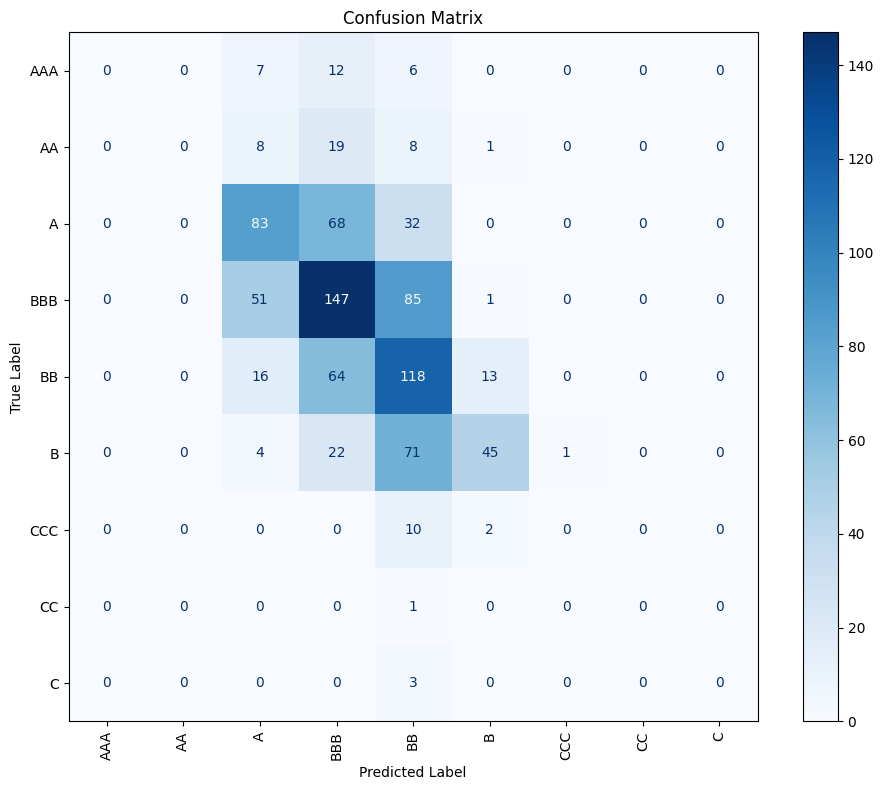

In [223]:
numeric_feature_columns = ["Altman_Z"]
cat_feature_columns = ['Sector']
target_column = "Rating"
custom_mapping = {'AAA': 0, 'AA': 1, 'A': 2, 'BBB': 3, 'BB': 4, 'B': 5, 'CCC': 6,"CC":7,"C":8,"D":9}
train_and_evaluate_model(df,numeric_feature_columns,cat_feature_columns,target_column,custom_mapping,solver = "lbfgs", penalty='l2')

### model 2
we only use tabular financial features

{'accuracy': 0.5756613756613757, 'f1_score': 0.5634800177431954, 'majority_baseline': 0.3100529100529101}
Share of predictions exactly as the actual: 57.57%
Share of predictions 1 or fewer ratings away from actual: 89.42%


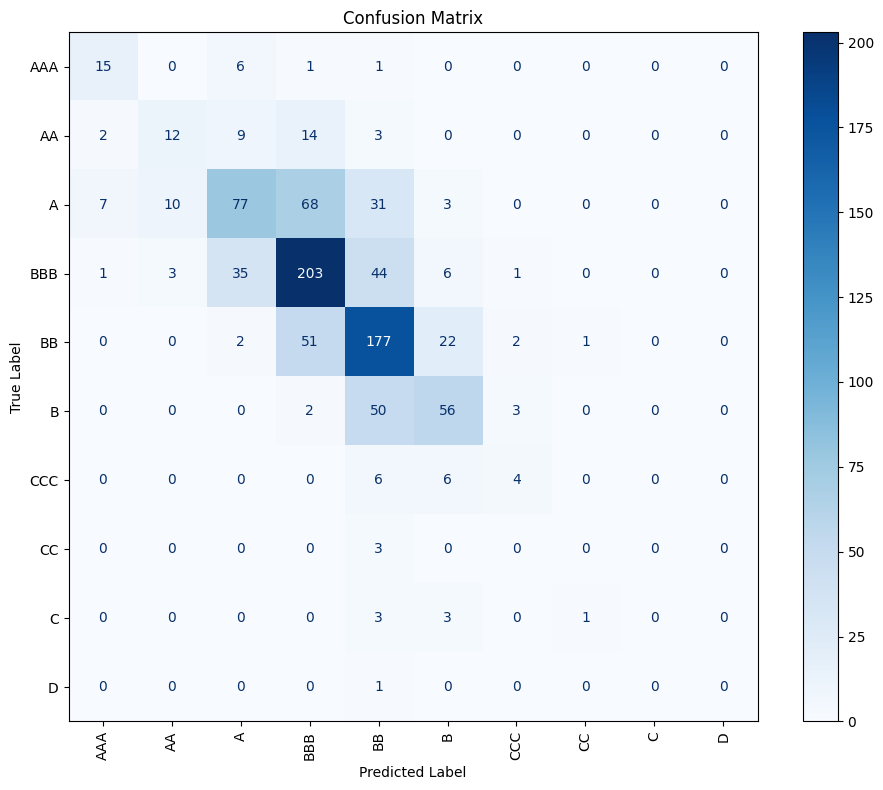

In [224]:
# Extract feature and target column names from the JSON data
cat_feature_columns = []
nlp_feature_columns = []
tabular_feature_columns = column_data['tabular_feature_columns']
target_column = column_data['target_column']

# Construct the features DataFrame
numeric_feature_columns = tabular_feature_columns + nlp_feature_columns

custom_mapping = {'AAA': 0, 'AA': 1, 'A': 2, 'BBB': 3, 'BB': 4, 'B': 5, 'CCC': 6,"CC":7,"C":8,"D":9}
train_and_evaluate_model(df,numeric_feature_columns,cat_feature_columns,target_column,custom_mapping,test_size=0.2, random_state=2,solver = "lbfgs", penalty='l2')

### model 3
We add the categorical features (cat+fin_tabular)

{'accuracy': 0.8, 'f1_score': 0.7985842179977781, 'majority_baseline': 0.3100529100529101}
Share of predictions exactly as the actual: 80.00%
Share of predictions 1 or fewer ratings away from actual: 97.88%


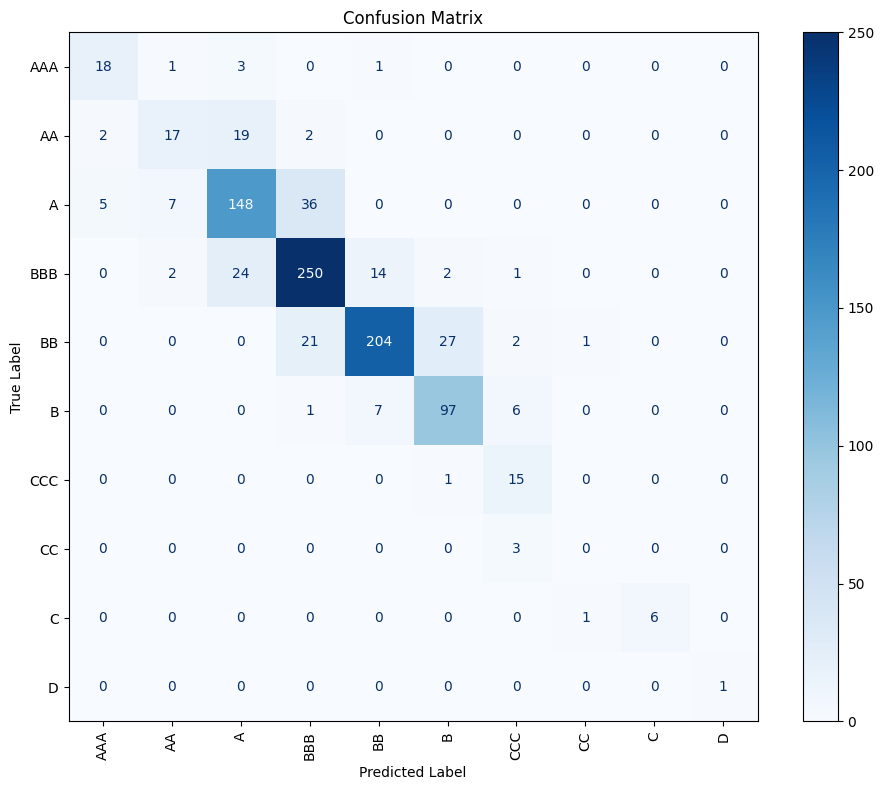

In [225]:
# Extract feature and target column names from the JSON data
cat_feature_columns = column_data['cat_feature_columns']
nlp_feature_columns = []
tabular_feature_columns = column_data['tabular_feature_columns']
target_column = column_data['target_column']

# Construct the features DataFrame
numeric_feature_columns = tabular_feature_columns + nlp_feature_columns


custom_mapping = {'AAA': 0, 'AA': 1, 'A': 2, 'BBB': 3, 'BB': 4, 'B': 5, 'CCC': 6,"CC":7,"C":8,"D":9}
train_and_evaluate_model(df,numeric_feature_columns,cat_feature_columns,target_column,custom_mapping,test_size=0.2, random_state=2,solver = "lbfgs", penalty='l2')

### model 4
We add the nlp features (nlp+cat+fin_tabular)

{'accuracy': 0.8042328042328042, 'f1_score': 0.803487151869701, 'majority_baseline': 0.3100529100529101}
Share of predictions exactly as the actual: 80.42%
Share of predictions 1 or fewer ratings away from actual: 97.88%


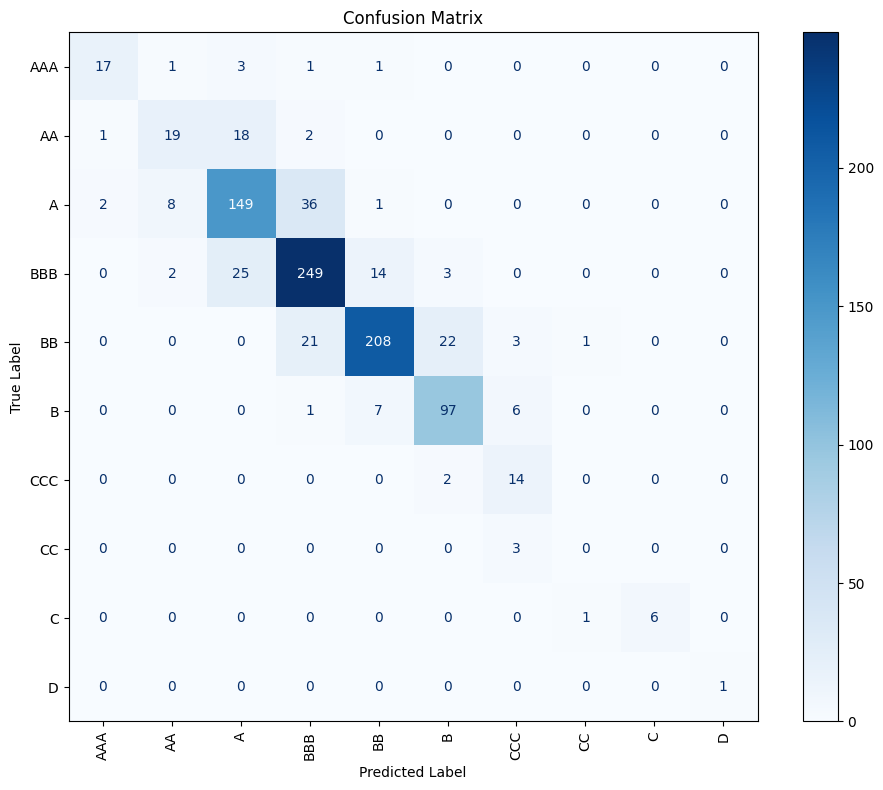

In [226]:
# Extract feature and target column names from the JSON data
cat_feature_columns = column_data['cat_feature_columns']
nlp_feature_columns = column_data['nlp_feature_columns']
tabular_feature_columns = column_data['tabular_feature_columns']
target_column = column_data['target_column']

# Construct the features DataFrame
numeric_feature_columns = tabular_feature_columns + nlp_feature_columns

custom_mapping = {'AAA': 0, 'AA': 1, 'A': 2, 'BBB': 3, 'BB': 4, 'B': 5, 'CCC': 6,"CC":7,"C":8,"D":9}
train_and_evaluate_model(df,numeric_feature_columns,cat_feature_columns,target_column,custom_mapping,test_size=0.2, random_state=2,solver = "lbfgs", penalty='l2')

## Task2: Credit Rating Changing Prediction 

# model 1
We add all variables

{'accuracy': 0.9248677248677248, 'f1_score': 0.8938523696082794, 'majority_baseline': 0.9301587301587302}
Share of predictions exactly as the actual: 92.49%
Share of predictions 1 or fewer ratings away from actual: 100.00%


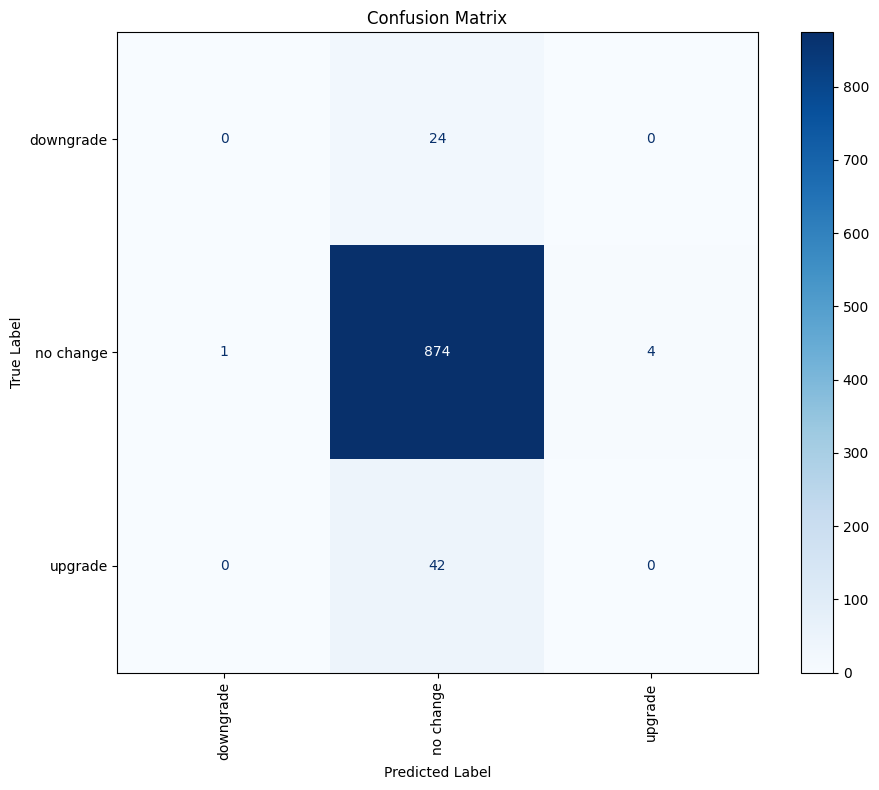

In [227]:
# Extract feature and target column names from the JSON data
cat_feature_columns = column_data['cat_feature_columns']
nlp_feature_columns = column_data['nlp_feature_columns']
tabular_feature_columns = column_data['tabular_feature_columns']
target_column = 'Change Since Last Fixed Quarter Date'

# Construct the features DataFrame
numeric_feature_columns = tabular_feature_columns + nlp_feature_columns

custom_mapping = {'downgrade': 0, 'no change': 1, 'upgrade': 2}

train_and_evaluate_model(df,numeric_feature_columns,cat_feature_columns,target_column,custom_mapping,test_size=0.2, random_state=2,solver = "lbfgs", penalty='l2',change=True)